In [1]:
# Developing code for "Direct Offset measuremeNts UTilizing Electro Optic Sampling (DONUT-EOS)"
from importlib import reload as rel;
import matplotlib.pyplot as plt;
import numpy as np;
from scipy.constants import c, epsilon_0;
from scipy.interpolate import interp1d, interp2d;
from scipy.optimize import curve_fit as cf;
from scipy.signal import find_peaks;
from time import time;
eps0 = epsilon_0;
import sys;
sys.path.insert(0, "../../python");
sys.path.insert(0, "..\\..\\python");
sys.path.insert(0, "../transverse_resolution/");
# Custom modules
from crystal import crystal;
from ebeam import ebeam;
from laser import laser;
import phase_retard as pr;
from plotting import makefig;
import thz;
import vertical_resolution as vr;
import donut as dn;
dn = rel(dn)

In [2]:
# Bunch parameters
################################################################################
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
sigz    = 5.2e-6;
sigt    = sigz / c;
del_z   = 150e-6;
del_t   = del_z / c;
N       = 8000;
t_beams = np.linspace(-N * sigt / 2, N * sigt / 2, N);
drive   = ebeam({'Q' : Q_drive, 'sigz' : sigz, 'del_z' : 0, 't' : t_beams});
wit     = ebeam({'Q' : Q_wit, 'sigz' : sigz, 'del_z' : del_z, 't' : t_beams});
################################################################################
# Crystal parameters
ctype = 'GaP';
d     = 100e-6;
x     = 1e-2;
y     = 1e-2;
rez   = 10e-6;
nx    = int(x/rez);
ny    = int(y/rez);
x0    = [0.1e-3, 0.1e-3]
y0    = [0.0e-3, 0.0e-3];
x_arr = np.linspace(-x/2, x/2, nx);
y_arr = np.linspace(-y/2, y/2, ny);
tau   = np.zeros((len(x_arr), len(y_arr)));

################################################################################
# Probe laser
lambda0 = 800e-9;
dy = 27e-9;
tp = 30e-15;
psi = 15;
psi_rad = psi * np.pi / 180;
probe = laser({'y0' : lambda0, 'dy' : dy, 'tp' : tp})
td    = 4.0e-12;

In [3]:
# Horizontal resolution -- drive beam
dx = np.array([-100, -50, 0, 50, 100]) * 1e-6;
theta = np.linspace(0, 2 * np.pi, len(x_arr));
drive_lineouts = np.zeros((len(dx), len(theta)));
x_int = np.linspace(-x/2, x/2, 1000);
y_int = np.linspace(-y/2, y/2, 1000);
y0    = [0, 0];
for i in range(len(dx)):
    print(i + 1, "of", len(dx));
    x0 = [dx[i], 0];
    g_drive, g_wit, gma = dn.get_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td);
    f_gma   = interp2d(x_int, y_int, gma);
    gma_int = f_gma(x_arr, y_arr); 
    sig     = np.sin(gma_int / 2)**2;
    sig_polar, azi_drive, azi_wit = dn.azi_lineout(sig, x_arr, y_arr);
    drive_lineouts[i, :] = azi_drive;

1 of 5
Initalizing for loop...
Looping...
2 of 5
Initalizing for loop...
Looping...
3 of 5
Initalizing for loop...
Looping...
4 of 5
Initalizing for loop...
Looping...
5 of 5
Initalizing for loop...
Looping...


Offset =  -100.0 A =  0.056 phi =  0.0 B =  0.939
Offset =  -50.0 A =  0.028 phi =  0.0 B =  0.938
Offset =  0.0 A =  0.0 phi =  1.571 B =  0.938
Offset =  50.0 A =  -0.028 phi =  -0.0 B =  0.938
Offset =  100.0 A =  -0.056 phi =  -0.0 B =  0.939


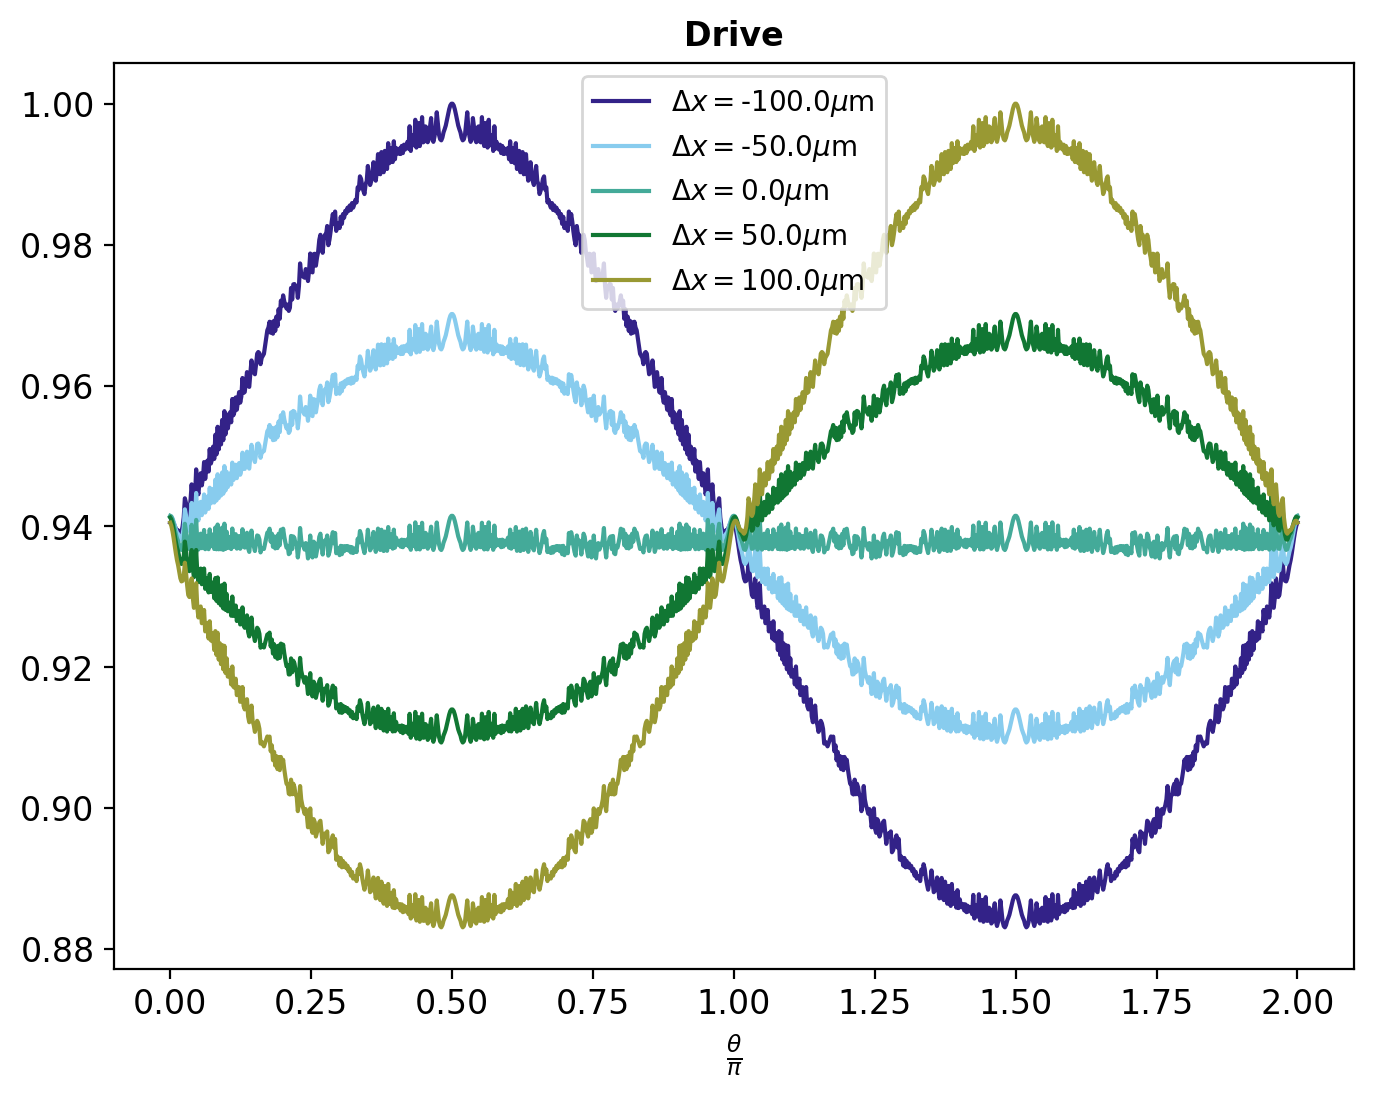

In [4]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\frac{\theta}{\pi}$', title = 'Drive');
for i in range(len(dx)):
    norm = np.amax(drive_lineouts);
    line = drive_lineouts[i, :] / norm;
    fit_line, popt = dn.fit_lineout(line, theta);
    print("Offset = ", np.round(dx[i] * 1e6), "A = ", np.round(popt[0], 3),  "phi = ", np.round(popt[1], 3), \
                                    "B = ",  np.round(popt[2], 3))
    label = r'$\Delta x = $' + str(np.round(dx[i] * 1e6)) + r'$\mu$m';
    ax.plot(theta / np.pi, drive_lineouts[i, :] / norm, label = label);
ax.legend();
plt.show()

In [6]:
# Horizontal resolution -- witness beam
dx = np.array([-100, -50, 0, 50, 100]) * 1e-6;
theta = np.linspace(0, 2 * np.pi, len(x_arr));
wit_lineouts = np.zeros((len(dx), len(theta)));
x_int = np.linspace(-x/2, x/2, 1000);
y_int = np.linspace(-y/2, y/2, 1000);
y0    = [0, 0];
for i in range(len(dx)):
    print(i + 1, "of", len(dx));
    x0 = [0, dx[i]];
    g_drive, g_wit, gma = dn.get_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td);
    f_gma   = interp2d(x_int, y_int, gma);
    gma_int = f_gma(x_arr, y_arr); 
    sig     = np.sin(gma_int / 2)**2;
    sig_polar, azi_drive, azi_wit = dn.azi_lineout(sig, x_arr, y_arr);
    drive_ind = np.argmax(sig_polar[:, 0]);
    offset    = 50;
    wit_ind   = np.argmax(sig_polar[drive_ind+offset:-1, 0]) + drive_ind + offset;
    wit_lineout = sig_polar[wit_ind, :];
    wit_lineouts[i, :] = wit_lineout;

1 of 5
Initalizing for loop...
Looping...
2 of 5
Initalizing for loop...
Looping...
3 of 5
Initalizing for loop...
Looping...
4 of 5
Initalizing for loop...
Looping...
5 of 5
Initalizing for loop...
Looping...


Offset =  -100.0 A =  0.04 phi =  0.0 B =  0.95
Offset =  -50.0 A =  0.02 phi =  0.001 B =  0.95
Offset =  0.0 A =  0.0 phi =  1.571 B =  0.949
Offset =  50.0 A =  -0.02 phi =  -0.001 B =  0.95
Offset =  100.0 A =  -0.04 phi =  -0.0 B =  0.95


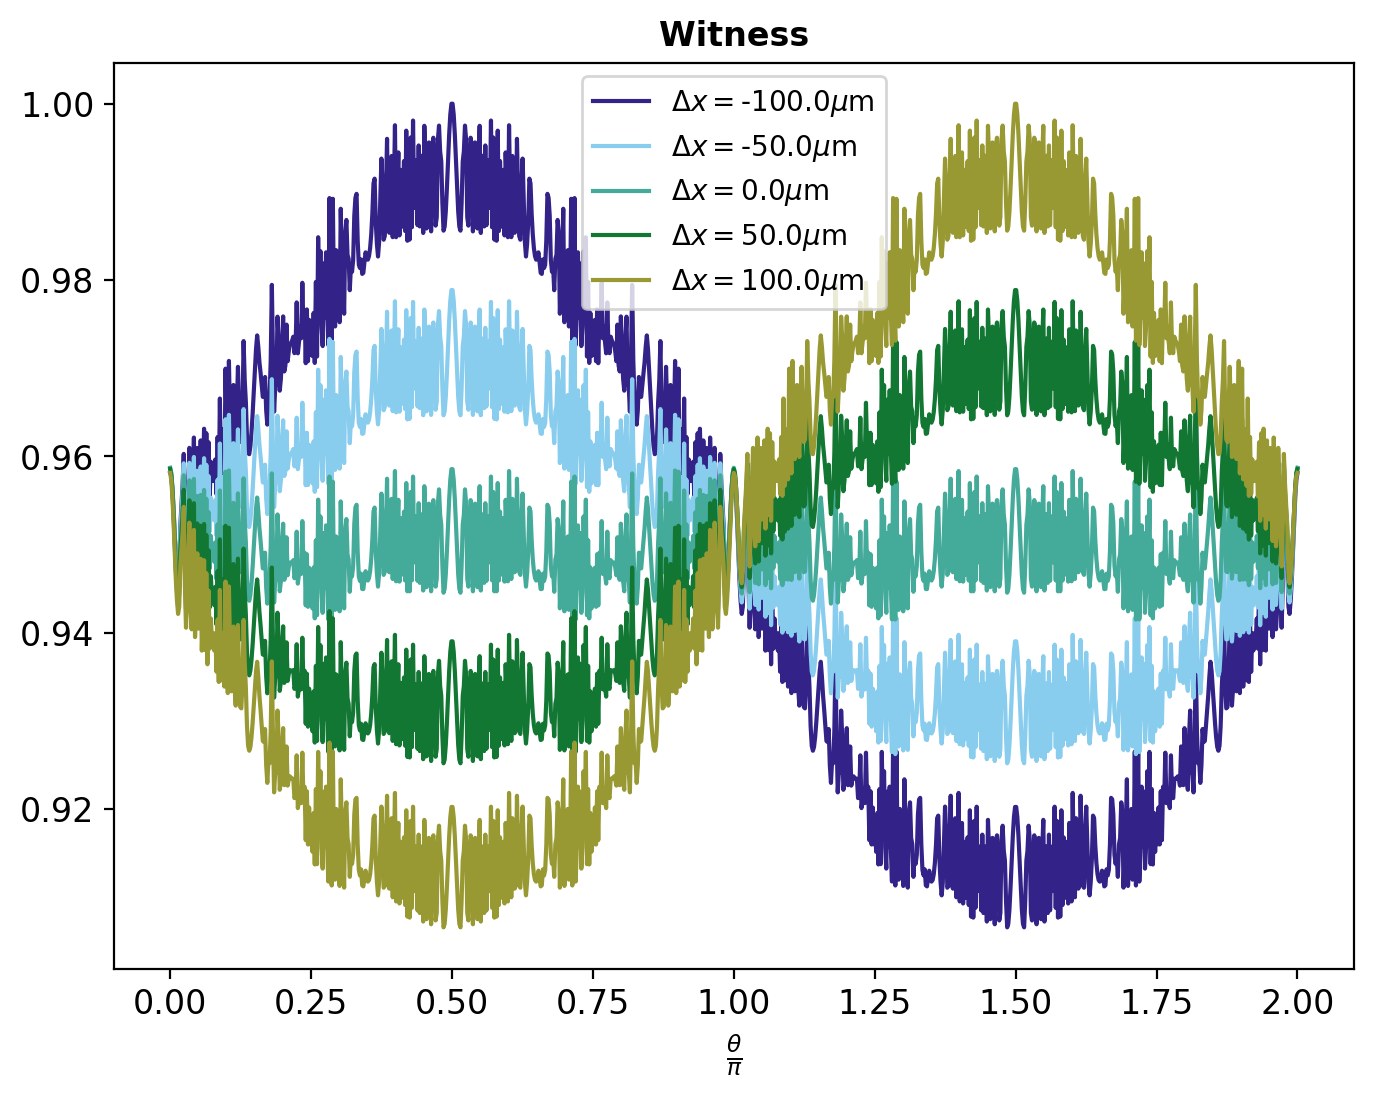

In [8]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\frac{\theta}{\pi}$', title = 'Witness');
norm = np.amax(wit_lineouts);
for i in range(len(dx)):
    line = wit_lineouts[i, :] / norm;
    fit_line, popt = dn.fit_lineout(line, theta);
    print("Offset = ", np.round(dx[i] * 1e6), "A = ", np.round(popt[0], 3),  "phi = ", np.round(popt[1], 3), \
                                    "B = ",  np.round(popt[2], 3))
    label = r'$\Delta x = $' + str(np.round(dx[i] * 1e6)) + r'$\mu$m';
    ax.plot(theta / np.pi, wit_lineouts[i, :] / norm, label = label);
ax.legend();
plt.show()

In [10]:
# Vertical resolution -- drive beam
dy = np.array([-100, -50, 0, 50, 100]) * 1e-6;
theta = np.linspace(0, 2 * np.pi, len(x_arr));
drive_lineouts = np.zeros((len(dx), len(theta)));
x_int = np.linspace(-x/2, x/2, 1000);
y_int = np.linspace(-y/2, y/2, 1000);
x0    = [0, 0];
for i in range(len(dx)):
    print(i + 1, "of", len(dx));
    y0 = [dy[i], 0];
    g_drive, g_wit, gma = dn.get_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td);
    f_gma   = interp2d(x_int, y_int, gma);
    gma_int = f_gma(x_arr, y_arr); 
    sig     = np.sin(gma_int / 2)**2;
    sig_polar, azi_drive, azi_wit = dn.azi_lineout(sig, x_arr, y_arr);
    drive_lineouts[i, :] = azi_drive;

1 of 5
Initalizing for loop...
Looping...
2 of 5
Initalizing for loop...
Looping...
3 of 5
Initalizing for loop...
Looping...
4 of 5
Initalizing for loop...
Looping...
5 of 5
Initalizing for loop...
Looping...


Offset =  -100.0 A =  0.056 phi =  1.571 B =  0.939
Offset =  -50.0 A =  0.028 phi =  1.571 B =  0.938
Offset =  0.0 A =  0.0 phi =  1.0 B =  0.938
Offset =  50.0 A =  -0.028 phi =  1.57 B =  0.938
Offset =  100.0 A =  -0.056 phi =  1.571 B =  0.939


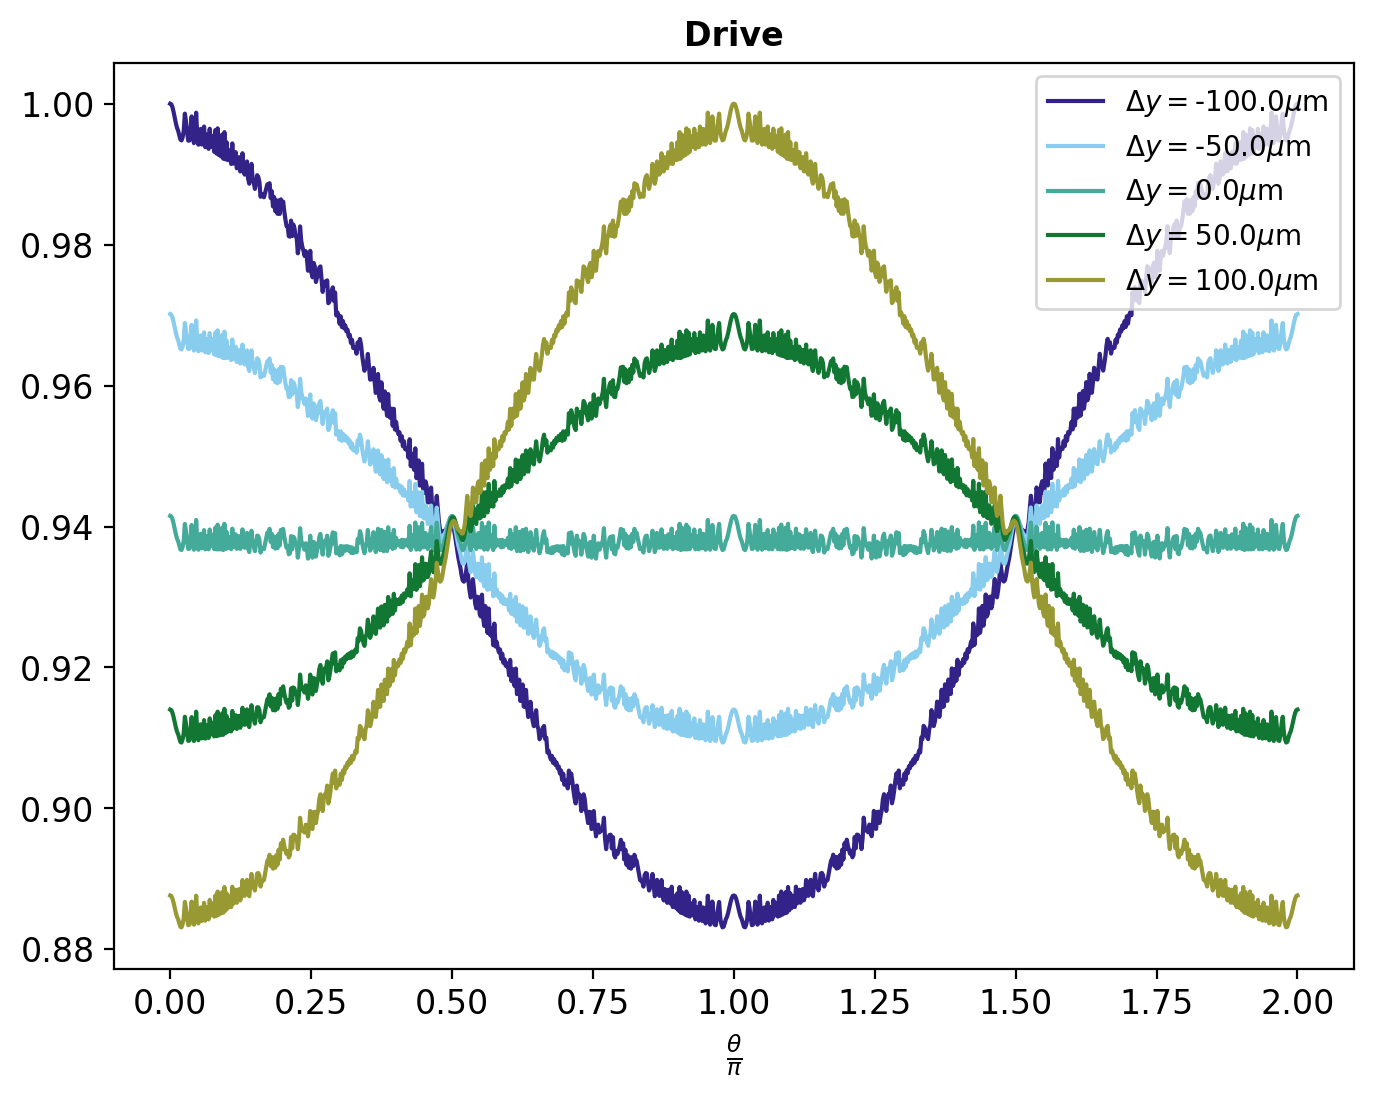

In [11]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\frac{\theta}{\pi}$', title = 'Drive');
for i in range(len(dy)):
    norm = np.amax(drive_lineouts);
    line = drive_lineouts[i, :] / norm;
    fit_line, popt = dn.fit_lineout(line, theta);
    print("Offset = ", np.round(dy[i] * 1e6), "A = ", np.round(popt[0], 3),  "phi = ", np.round(popt[1], 3), \
                                    "B = ",  np.round(popt[2], 3))
    label = r'$\Delta y = $' + str(np.round(dx[i] * 1e6)) + r'$\mu$m';
    ax.plot(theta / np.pi, drive_lineouts[i, :] / norm, label = label);
ax.legend();
plt.show()

In [18]:
# Vertical resolution -- witness beam
dy = np.array([-100, -50, 0, 50, 100]) * 1e-6;
theta = np.linspace(0, 2 * np.pi, len(x_arr));
wit_lineouts = np.zeros((len(dy), len(theta)));
x_int = np.linspace(-x/2, x/2, 1000);
y_int = np.linspace(-y/2, y/2, 1000);
x0 = [0, 0];
for i in range(len(dy)):
    print(i + 1, "of", len(dy));
    y0 = [0, dy[i]];
    g_drive, g_wit, gma = dn.get_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td);
    f_gma   = interp2d(x_int, y_int, gma, kind = 'cubic');
    gma_int = f_gma(x_arr, y_arr); 
    sig     = np.sin(gma_int / 2)**2;
    sig_polar, azi_drive, azi_wit = dn.azi_lineout(sig, x_arr, y_arr);
    wit_lineouts[i, :] = azi_wit;

1 of 5
Initalizing for loop...
Looping...
2 of 5
Initalizing for loop...
Looping...
3 of 5
Initalizing for loop...
Looping...
4 of 5
Initalizing for loop...
Looping...
5 of 5
Initalizing for loop...
Looping...


Offset =  -100.0 A =  0.04 phi =  1.571 B =  0.954
Offset =  -50.0 A =  0.02 phi =  1.571 B =  0.953
Offset =  0.0 A =  0.0 phi =  1.571 B =  0.953
Offset =  50.0 A =  -0.02 phi =  1.571 B =  0.953
Offset =  100.0 A =  -0.04 phi =  1.571 B =  0.954


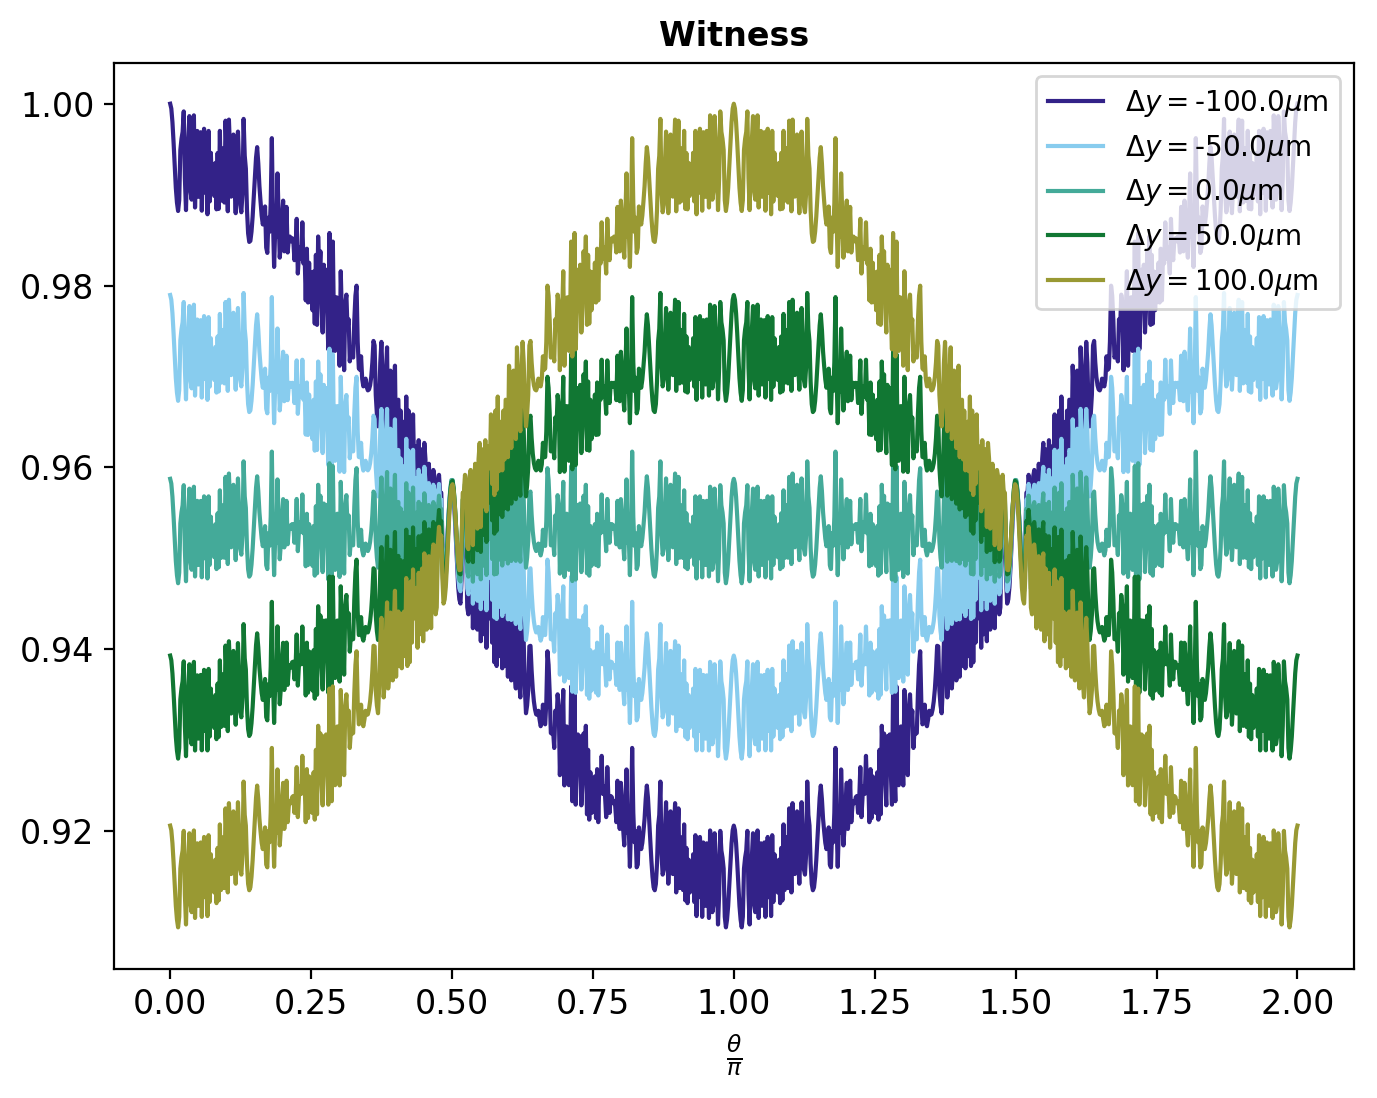

In [19]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\frac{\theta}{\pi}$', title = 'Witness');
for i in range(len(dy)):
    norm = np.amax(wit_lineouts);
    line = wit_lineouts[i, :] / norm;
    fit_line, popt = dn.fit_lineout(line, theta);
    print("Offset = ", np.round(dy[i] * 1e6), "A = ", np.round(popt[0], 3),  "phi = ", np.round(popt[1], 3), \
                                    "B = ",  np.round(popt[2], 3))
    label = r'$\Delta y = $' + str(np.round(dy[i] * 1e6)) + r'$\mu$m';
    ax.plot(theta / np.pi, wit_lineouts[i, :] / norm, label = label);
ax.legend();
plt.show()

In [23]:
# Combined offset drive bunch
offsets = ([100e-6*np.sqrt(3), 100e-6], [100e-6, 100e-6], [100e-6, 100e-6*np.sqrt(3)]);
theta = np.linspace(0, 2 * np.pi, len(x_arr));
drive_lineouts = np.zeros((len(offsets), len(theta)));
x_int = np.linspace(-x/2, x/2, 1000);
y_int = np.linspace(-y/2, y/2, 1000);
for i in range(len(offsets)):
    print(i+1, "of", len(offsets));
    x0                            = [offsets[i][0], 0];
    y0                            = [offsets[i][1], 0];
    g_drive, g_wit, gma           = dn.get_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td);
    f_gma                         = interp2d(x_int, y_int, gma);
    gma_int                       = f_gma(x_arr, y_arr); 
    sig                           = np.sin(gma_int / 2)**2;
    sig_polar, azi_drive, azi_wit = dn.azi_lineout(sig, x_arr, y_arr);
    drive_lineouts[i, :]          = azi_drive; 

1 of 3
Initalizing for loop...
Looping...
2 of 3
Initalizing for loop...
Looping...
3 of 3
Initalizing for loop...
Looping...


Offset =  -100.0 A =  -0.106 phi =  0.524 B =  0.886
Offset =  -50.0 A =  -0.075 phi =  0.785 B =  0.885
Offset =  0.0 A =  -0.106 phi =  1.047 B =  0.886


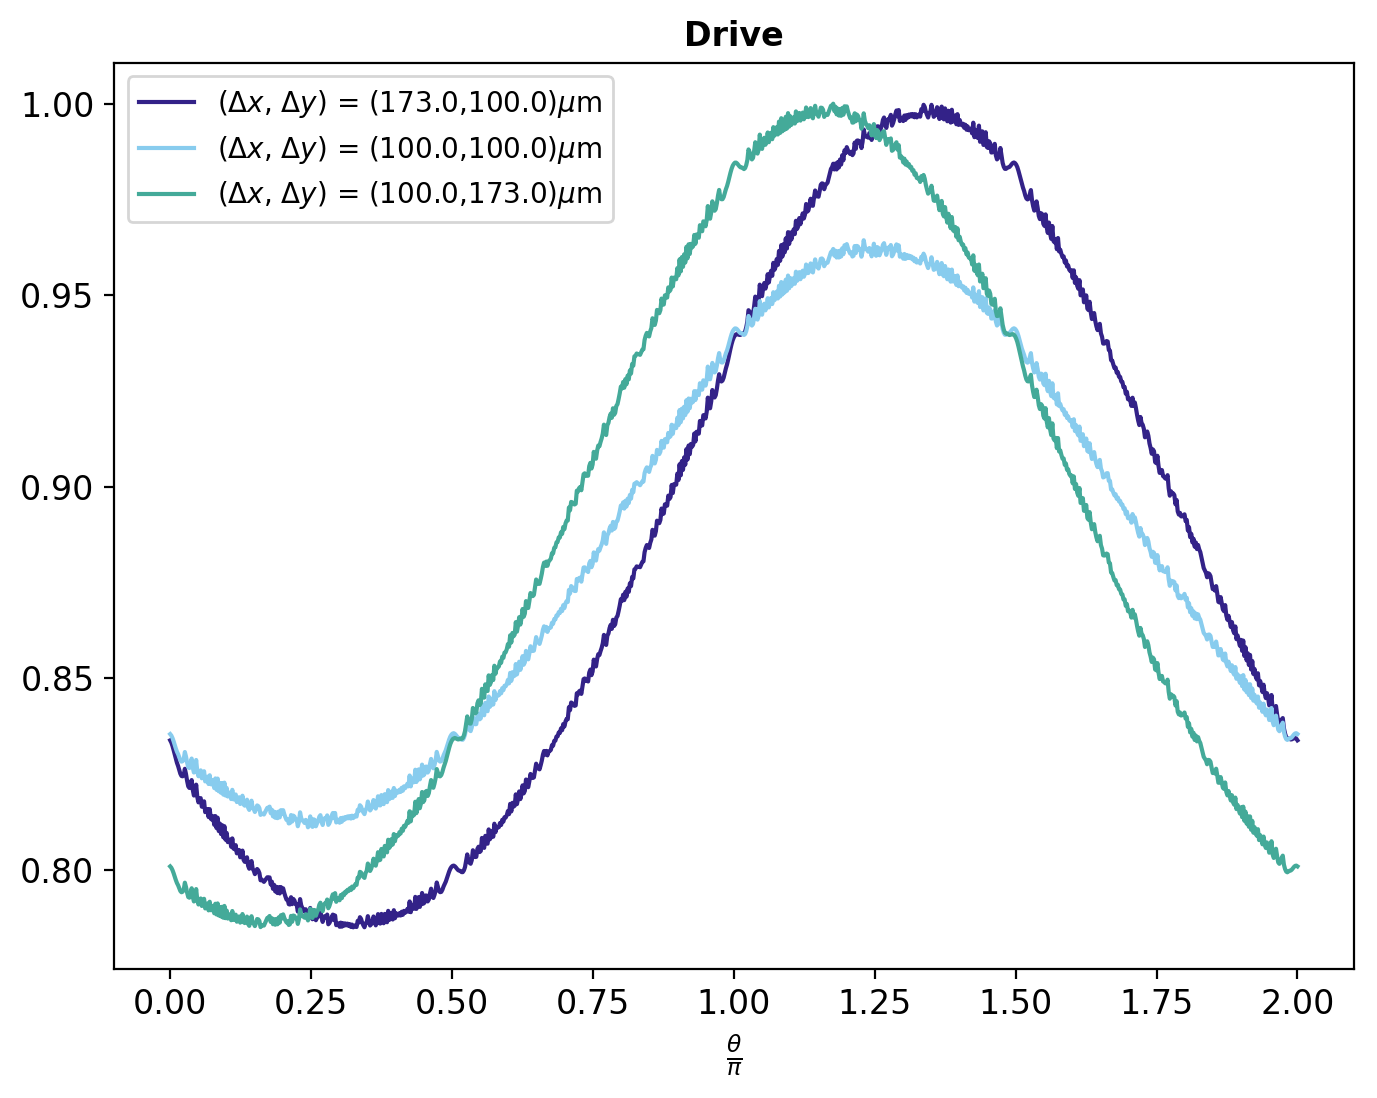

In [26]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\frac{\theta}{\pi}$', title = 'Drive');
for i in range(len(offsets)):
    norm = np.amax(drive_lineouts);
    line = drive_lineouts[i, :] / norm;
    fit_line, popt = dn.fit_lineout(line, theta);
    print("Offset = ", np.round(dy[i] * 1e6), "A = ", np.round(popt[0], 3),  "phi = ", np.round(popt[1], 3), \
                                    "B = ",  np.round(popt[2], 3))
    label = r'($\Delta x $, $\Delta y$) = (' + str(np.round(offsets[i][0] * 1e6)) + ',' + \
              str(np.round(offsets[i][1] * 1e6)) + r')$\mu$m';
    ax.plot(theta / np.pi, drive_lineouts[i, :] / norm, label = label);
ax.legend();
plt.show()

In [27]:
# Combined offset witness bunch
offsets = ([100e-6*np.sqrt(3), 100e-6], [100e-6, 100e-6], [100e-6, 100e-6*np.sqrt(3)]);
theta = np.linspace(0, 2 * np.pi, len(x_arr));
wit_lineouts = np.zeros((len(offsets), len(theta)));
x_int = np.linspace(-x/2, x/2, 1000);
y_int = np.linspace(-y/2, y/2, 1000);
for i in range(len(offsets)):
    print(i+1, "of", len(offsets));
    x0                            = [0, offsets[i][0]];
    y0                            = [0, offsets[i][1]];
    g_drive, g_wit, gma           = dn.get_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td);
    f_gma                         = interp2d(x_int, y_int, gma);
    gma_int                       = f_gma(x_arr, y_arr); 
    sig                           = np.sin(gma_int / 2)**2;
    sig_polar, azi_drive, azi_wit = dn.azi_lineout(sig, x_arr, y_arr);
    wit_lineouts[i, :]            = azi_wit; 

1 of 3
Initalizing for loop...
Looping...
2 of 3
Initalizing for loop...
Looping...
3 of 3
Initalizing for loop...
Looping...


Offset =  -100.0 A =  -0.076 phi =  0.523 B =  0.911
Offset =  -50.0 A =  -0.054 phi =  0.785 B =  0.91
Offset =  0.0 A =  -0.076 phi =  1.047 B =  0.911


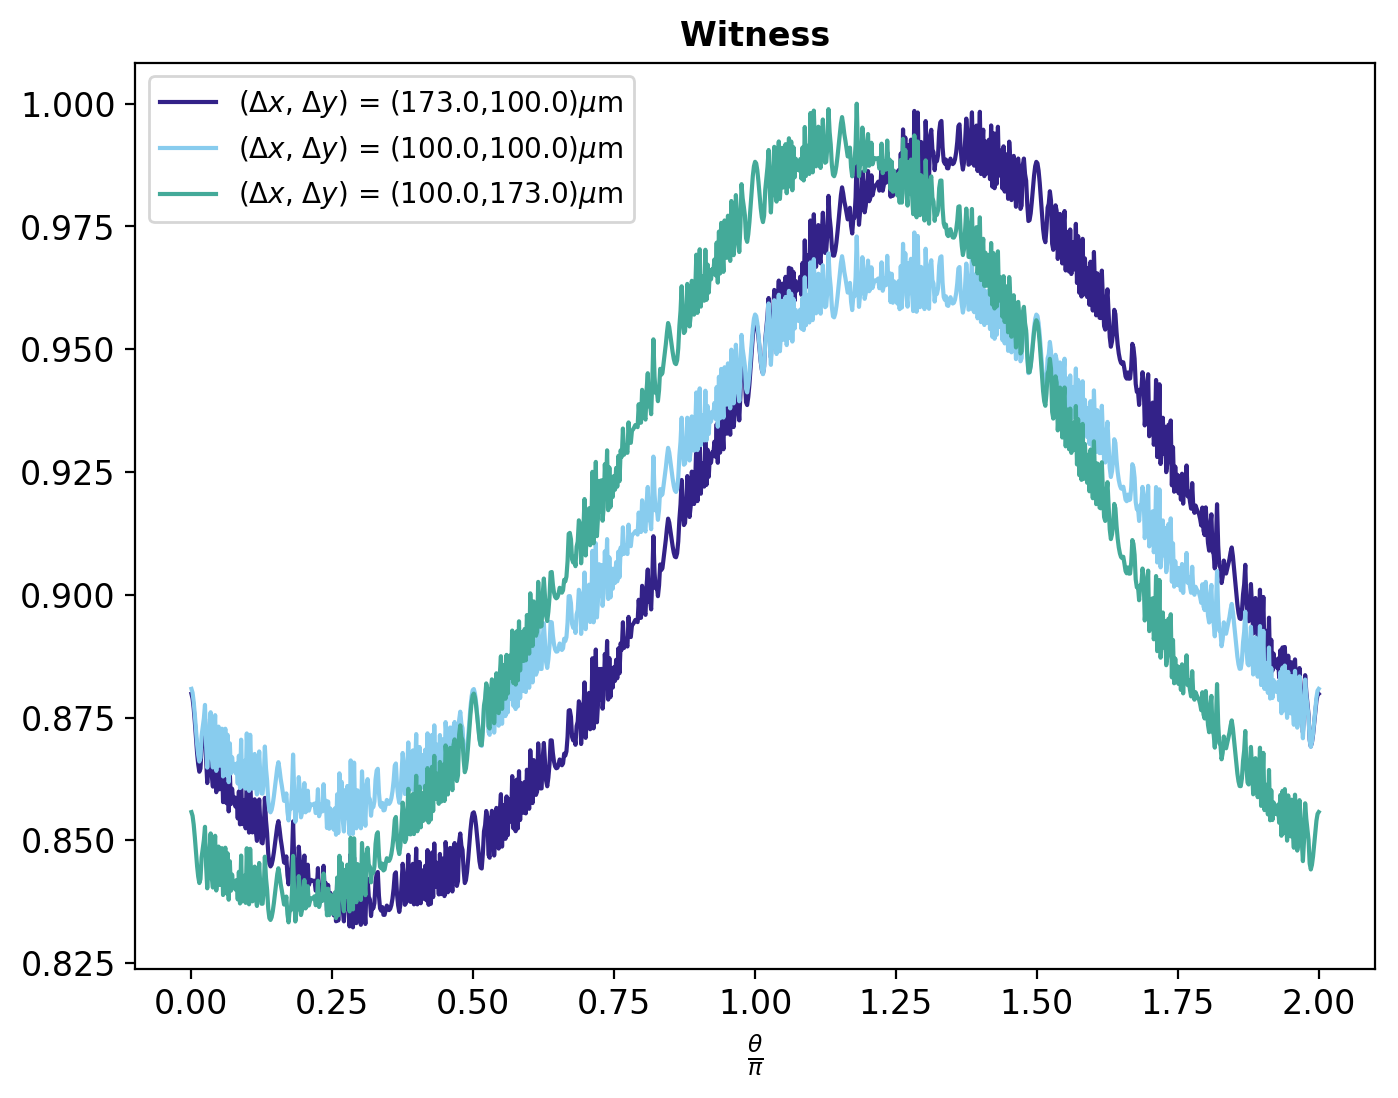

In [29]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\frac{\theta}{\pi}$', title = 'Witness');
for i in range(len(offsets)):
    norm = np.amax(wit_lineouts);
    line = wit_lineouts[i, :] / norm;
    fit_line, popt = dn.fit_lineout(line, theta);
    print("Offset = ", np.round(dy[i] * 1e6), "A = ", np.round(popt[0], 3),  "phi = ", np.round(popt[1], 3), \
                                    "B = ",  np.round(popt[2], 3))
    label = r'($\Delta x $, $\Delta y$) = (' + str(np.round(offsets[i][0] * 1e6)) + ',' + \
              str(np.round(offsets[i][1] * 1e6)) + r')$\mu$m';
    ax.plot(theta / np.pi, wit_lineouts[i, :] / norm, label = label);
ax.legend();
plt.show()